In [1]:
from treys import Card, Evaluator


In [2]:
board = [Card.new('Ah'),Card.new('Kd'),Card.new('Jc')]
hand = [Card.new('Qs'),Card.new('Th')]

In [6]:
from treys import Evaluator
evaluator = Evaluator()
print(evaluator.evaluate(board,hand))

1600


In [7]:
community_card=  []
hand_cards=  [67144223, 1065995]
evaluator = Evaluator()
print(evaluator.evaluate(hand_cards, community_card))

KeyError: 2

In [51]:
import math
import holdem.utils
import numpy as np
import gym
import holdem
from treys import Card
import holdem.DQN as DQN
import holdem.safePlayer as safePlayer
import tensorflow as tf

class action_table:
  CHECK = 0
  CALL = 1
  RAISE = 2
  FOLD = 3
    
def transferCard(cards):
    result = []
    for i in cards:
        rank = Card.get_rank_int(i)
        suit = Card.get_suit_int(i)
        suit = int(math.log2(suit))
        result.append(suit * 13 + rank)
    one_hot_encoding = np.zeros(52)
    one_hot_encoding[result] += 1
    return one_hot_encoding
        
def run_maze(model_list):
    step = 0
    how_many_round_ = [0,0,0,0]
    stack_record=[]
    last_rews = [3000000, 3000000, 3000000, 3000000]
    init_stack = [3000000, 3000000, 3000000, 3000000]
    for episode in range(1000):
        # initial observation
        (player_states, (community_infos, community_cards)) = env.reset()
        (player_infos, player_hands) = zip(*player_states)
        current_player = community_infos[-1]
        totalpot = community_infos[3]
        to_call = community_infos[6]
        stack = player_infos[current_player][2]
        handrank = player_infos[current_player][4]
#         print(handrank)
        betting = init_stack[current_player] - stack
        cards = [x for x in community_cards if x!=-1] + player_hands[current_player] * 2
#         print(player_hands)
        cards = transferCard(cards)
        
        # print(community_infos)
        
        # env.render(mode='human')
        terminal = False
        how_many_round=[0,0,0,0]
        if episode%1000==0:
            print(episode/1000, ' round finished')
        
        while not terminal:
            RL = model_list[current_player]
            action = RL.choose_action(np.concatenate(([
                                    totalpot,
                                    handrank],cards)))
            # first reound cannot check
#             print(action == 1 and to_call == 0)
#             print('action = ',action)
#             print()
#             if (action == 0 and cards.sum() == 2.0):
#                 action = 1
            if(action == 1 and to_call == 0):
                action = 0
            # cannot check when encounter other raised
            elif(action == 0 and to_call != 0):
                action = 1
            elif(action == 3 and to_call == 0):
                action = 0
            # print(action, cards.sum())
            result = [[0,0],[0,0],[0,0],[0,0]]
            result[current_player][0] = action
            if action==2:
                if stack < community_infos[5]:
                    result[current_player][0] = 1
                else:
                    result[current_player][1] = max(community_infos[4] + 10, 25)
            action = result
#             if current_player == 0:
#                 print(action[current_player])
            # print(to_call)
#             print('action = ',action)
#             print('to_call = ', to_call)
            # rewards is an array
            (player_states_, (community_infos_, community_cards_)), rews, terminal, info = env.step(action)
#             env.render(mode='human')
            (player_infos_, player_hands_) = zip(*player_states)
#             print(player_infos_)
#             print('rewards = ', rews)
#             print('betting = ', betting)
#             print('terminal = ', terminal)
#             print(stack)
#             print('to_call= ',to_call)
            current_player_ = community_infos_[-1]
            betting_ = init_stack[current_player] - stack
            totalpot_ = community_infos_[3]
            to_call_ = community_infos_[6]
            stack_ = player_infos_[current_player][2]
            handrank_ = player_infos_[current_player][4]
            cards_ = [x for x in community_cards_ if x!=-1] + player_hands[current_player_] 
            cards_ = transferCard(cards_)
            
            
            RL.store_transition(np.concatenate(([
                                totalpot,
                                handrank] , cards))
                                , action, [0,0,0,0], np.concatenate(([ 
                                                        totalpot_,
                                                        handrank_
                                                        ], cards_)), current_player)

            # swap observation
            how_many_round[current_player] += 1
            
            stack = stack_
            current_player = current_player_
            betting = betting_
            to_call = to_call_
            player_states = player_states_
            community_infos = community_infos_
            community_cards = community_cards_
#             env.render(mode='human')
            #print('========step{} finished========'.format(step))
            step += 1
        stack_record.append(rews)
        
        init_stack = rews
        this_round_rew = [0, 0, 0, 0]
        for i in range(len(this_round_rew)):
            this_round_rew[i] = rews[i] - last_rews[i]
#         print('replace reward as ', this_round_rew)
#         print('rews= ', rews)
#         print('last_rews= ', last_rews)
        last_rews = rews
#         for i in range(len(this_round_rew)):
#             if this_round_rew[i] < 0:
#                 this_round_rew[i] *= 10
        print('replace reward as ', this_round_rew)
        for i in range(4):
            model_list[i].replace_transition(this_round_rew[i], how_many_round_[i], how_many_round[i])
        if (step > 100):
            for i in range(4):
                model_list[i].learn()
    return stack_record
            



## save model

In [52]:
for i in range(1):
    env = gym.make('TexasHoldem-v1') # holdem.TexasHoldemEnv(2)

    # start with 2 players
    env.add_player(0, stack=3000000) # add a player to seat 0 with 2000 "chips"
    env.add_player(1, stack=3000000) # add another player to seat 1 with 2000 "chips"
    env.add_player(2, stack=3000000)
    env.add_player(3, stack=3000000)
    final_result=[]
    for i in range(1):
        stack_record = run_maze([RL2, SP, SP, SP])
        final_result.append(stack_record)
RL2.save_model()

0.0  round finished
replace reward as  [-110, -110, -110, 330]
replace reward as  [0, 50, -25, -25]
replace reward as  [-25, -25, -25, 75]
replace reward as  [-10, -25, -25, 60]
replace reward as  [-50, -50, 150, -50]
replace reward as  [0, -25, -25, 50]
replace reward as  [75, -25, -25, -25]
replace reward as  [-10, 60, -25, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [0, 50, -25, -25]
replace reward as  [-50, -50, 150, -50]
replace reward as  [-25, -25, 75, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [-25, 75, -25, -25]
replace reward as  [75, -25, -25, -25]
replace reward as  [-10, 60, -25, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [0, -25, 50, -25]
replace reward as  [-25, -25, -25, 75]
replace reward as  [-10, -25, 60, -25]
replace reward as  [0, -25, 50, -25]
replace reward as  [0, -25, 50, -25]
replace reward as  [-50, -50, 150, -50]
replace reward as  [75, -25, -25, -25]
replace reward as  [0, -25, 50, -25]
replace reward as 

replace reward as  [-25, 75, -25, -25]
replace reward as  [-10, -25, 60, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [-25, -25, -25, 75]
replace reward as  [-10, 60, -25, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [0, -25, -25, 50]
replace reward as  [76, -6, -20, -50]
replace reward as  [-10, -25, -25, 60]
replace reward as  [-35, -35, 105, -35]
replace reward as  [0, -25, -25, 50]
replace reward as  [25, -25, -25, 25]
replace reward as  [-70, 210, -70, -70]
replace reward as  [0, -25, 50, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [225, -75, -75, -75]
replace reward as  [-10, -25, 60, -25]
replace reward as  [0, 31, -6, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [180, -60, -60, -60]
replace reward as  [-10, 60, -25, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [-75, -75, -75, 225]
replace reward as  [150, -50, -50, -50]
replace reward as  [-10, 60, -25, -25]
rep

replace reward as  [-25, 75, -25, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [75, -25, -25, -25]
replace reward as  [-10, 60, -25, -25]
replace reward as  [-25, -25, -25, 75]
replace reward as  [-50, -50, -50, 150]
replace reward as  [75, -25, -25, -25]
replace reward as  [-10, -25, 60, -25]
replace reward as  [0, -25, 50, -25]
replace reward as  [-25, -25, 75, -25]
replace reward as  [-25, -25, 75, -25]
replace reward as  [-25, 75, -25, -25]
replace reward as  [0, -25, 50, -25]
replace reward as  [0, -25, 50, -25]
replace reward as  [-25, -25, 75, -25]
replace reward as  [-10, -25, -25, 60]
replace reward as  [0, -25, 50, -25]
replace reward as  [0, -25, 50, -25]
replace reward as  [150, -50, -50, -50]
replace reward as  [-10, -25, 60, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [0, -25, 50, -25]
replace reward as  [-25, -25, 75, -25]
replace reward as  [50, -25, -25, 0]
replace reward as  [0, 50, -25, -25]
replace reward as  [-25, 75, -25, -25]
repl

replace reward as  [-25, -25, -25, 75]
replace reward as  [-25, -25, 75, -25]
replace reward as  [75, -25, -25, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [0, 50, -25, -25]
replace reward as  [-25, -25, 75, -25]
replace reward as  [75, -25, -25, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [-25, -25, 75, -25]
replace reward as  [-50, -50, -50, 150]
replace reward as  [0, -25, 50, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [-25, -25, -25, 75]
replace reward as  [-10, -25, -25, 60]
replace reward as  [75, -25, -25, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [-75, -75, 225, -75]
replace reward as  [-10, -25, 60, -25]
replace reward as  [0, -25, -25, 50]
replace reward as  [0, -25, -25, 50]
replace reward as  [-25, -25, -25, 75]
replace reward as  [75, -25, -25, -25]
replace reward as  [0, -25, 50, -25]
replace reward as  [0, 50, -25, -25]
replace reward as  [150, -50, -50, -50]
repla

## load model

In [40]:
import math
import holdem.utils
import numpy as np
import gym
import holdem
from treys import Card
import holdem.DQN as DQN
import holdem.safePlayer as safePlayer
import tensorflow as tf

class action_table:
  CHECK = 0
  CALL = 1
  RAISE = 2
  FOLD = 3
tf.reset_default_graph()
RL2 = DQN.DeepQNetwork(4, 54,
                  learning_rate=0.00001,
                  reward_decay=0.999,
                  e_greedy=0.8,
                  replace_target_iter=500,
                  memory_size=100,
                  output_graph=True, nickname='2'
                  )

RL2.load_model()
SP = safePlayer.safePlayer()

INFO:tensorflow:Restoring parameters from ./models/model.ckpt


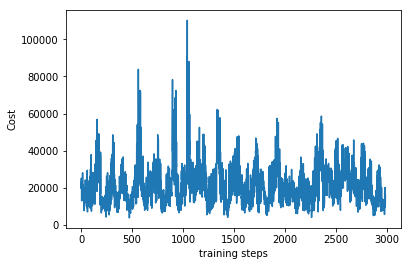

In [46]:
RL2.plot_cost()

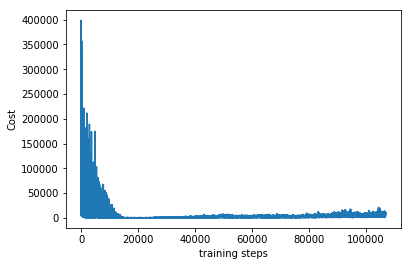

In [21]:
RL2.plot_cost()

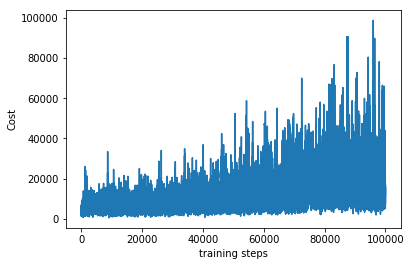

In [25]:
import matplotlib.pyplot as plt
RL2.plot_cost()

/usr/local/lib/python3.6/site-packages/matplotlib/legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


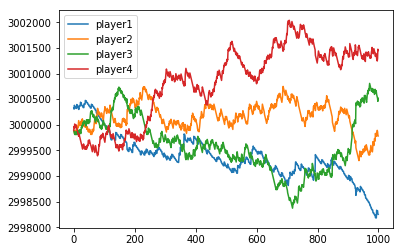

In [38]:
import matplotlib.pyplot as plt

a0=np.array(final_result[0])
# a1=np.array(final_result[1])
# a2=np.array(final_result[2])
# a3=np.array(final_result[3])
# stack_record = np.concatenate((a0, a1, a2))
stack_record = a0

test = np.array(stack_record)
test = np.transpose(test)
l1 = plt.plot(np.arange(len(test[0])), test[0])
l2 = plt.plot(np.arange(len(test[1])), test[1])
l3 = plt.plot(np.arange(len(test[2])), test[2])
l4 = plt.plot(np.arange(len(test[3])), test[3])
# l5 = plt.plot(np.arange(len(test[4])), test[4])
# l6 = plt.plot(np.arange(len(test[5])), test[5])
# l7 = plt.plot(np.arange(len(test[6])), test[6])
# l8 = plt.plot(np.arange(len(test[7])), test[7])
plt.legend([l1,l2,l3,l4],labels=['player1','player2','player3','player4'])
plt.show()

In [7]:
from websocket import create_connection
import json

In [28]:
ws = create_connection("ws://poker-training.vtr.trendnet.org:3001")
ws.send(json.dumps({
            "eventName": "__join",
            "data": {
                "playerName": "ppp"
            }
        }))
ws.recv()

'{"eventName":"__new_peer","data":[{"playerName":"f27f6f1c7c5cbf4e3e192e0a47b85300","isOnline":true},{"playerName":"828d51c39c87aad9b1407d409fa58e36","isOnline":true},{"playerName":"050fcc102c8dcc764e8342234da8d78f","isOnline":true},{"playerName":"17a169e8c69b2effd9315975ac833b78","isOnline":true},{"playerName":"a13fdaf9882ebf07cfea5f73df976e39","isOnline":true},{"playerName":"2c87c27ae47f26e13a880e32fa2db327","isOnline":true},{"playerName":"afb1c65720dc617c16b471157a0398b4","isOnline":true}]}'

In [29]:
ws.close()